[(30.0, 30.0), (60.0, 60.0), (30.0, 60.0)]
450.0


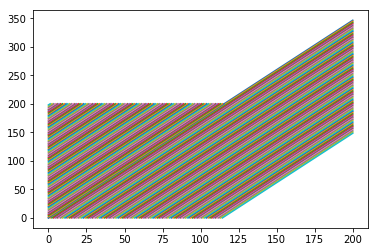

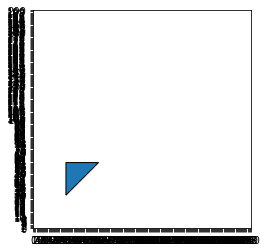

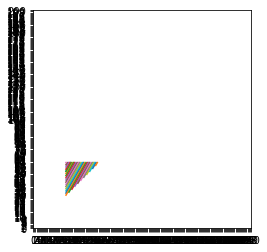

In [6]:
#This is the new gcode generator
#Gcode generator only works for 1 solid shape for now
#Probably can be repleaced with a Cura plugin/change to the CuraEngine backend
#^ Get a CS major to do this.  I tried looking at it, and it's dense

#make up general 1-material print, then add functionality for multiple material print

from shapely import geometry as geo
from matplotlib import pyplot
import numpy as np
from descartes.patch import PolygonPatch

def main(): #Change to __init__ later
    
    #INPUTS
    num_Mat = 1 #number of materials printing with
    layup = [45,-45] #angle sequence of part, domain [-180,180]
    spacing = 0.5 #spacing desired between lines, only uniform spacing for now
    file = open('gcode_test.gcode','r') #Import gcode from slicing engine
    #Add functionality to naturally adapt filename to input filename
    outputfile = open('exported_gcode.gcode','') #Write to new gcode file
    
    input_file = file.readlines() #import file line by line
    
    #Read each line and remove if not a G1 move
    boundary = extractBoundary(input_file)
    
    #list of layers
    layer_index = layers()
    
    #pre-block
    
    for i in range(len(layer_index)): #Operate on each layer at a time
        pass
        output_file.append(gcode_layer) #append to file
        
    #post-block
    
    
    #done
    print('done')
    
    return #generally return null for main func?

### Section: Parsing text file
def extractCoordinates(G1_line): #x and y coordinates as list
    coord = []
    x_coor = -1
    y_coor = -1
    commands = G1_line.split()
    for i in range(len(commands)): #might be better way of doing this
        if(commands[i][0]=='X'): #extract X coordinate
            x_coor = float(commands[i][1:len(commands[i])])
        if(commands[i][0]=='Y'): #extract Y coordinate
            y_coor = float(commands[i][1:len(commands[i])])
    if(x_coor==-1 and y_coor==-1):
        return
    coord = tuple([x_coor, y_coor])
    return coord #returns 1x2 list of float

def extractLayer(input_file): #List of coordinate list for each layer
    layer = [None]
    for i in range(len(input_file)):
        layer.append(extractCoordinates(input_file[i]))
    #clean "none" values
    layer = list(filter(None, layer))
    return layer

filename = 'test_document.txt'
filename = 'test_rectangle.txt'
filename = 'dogbone_1layer_F.txt'
filename = 'test_geometry.txt'
#filename = 'UM2E_Test_part_dogbone.gcode'
file = open(filename,'r')
test = file.read().splitlines() #readlines keeps a newline, so use splitlines instead
test2 = extractLayer(test)
print(test2)

def separateLayers(input_file): #separates into layers
    boundary = {}
    boundary[1]=5
    layer_index = [i for i, x in enumerate(input_file) if x=='new layer'] #find Layer points, list comprehension
    
    begin_index = 0
    end_index = len(input_file)
    for i in range(len(layer_index)):
        boundary[i] = extractLayer(input_file[begin_index:layer_index[i]])
        begin_index = layer_index[i]
    boundary[i+1]=extractLayer(input_file[layer_index[i]:end_index])
    del(boundary[0][0]) #filter out pre-block origin for now, might want to make a more flexible solution later
    return boundary

#test3 = [i for i, x in enumerate(test) if x=='new layer']
#test4 = separateLayers(test)

### Section: Plotting functions (taken from shapely source code example)
def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, 'o', color='#999999', zorder=1)

def plot_bounds(ax, ob):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color='#000000', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y)
def set_limits(ax, x0, xN, y0, yN):
    ax.set_xlim(x0, xN)
    ax.set_xticks(range(x0, xN+1))
    ax.set_ylim(y0, yN)
    ax.set_yticks(range(y0, yN+1))
    ax.set_aspect("equal")

### Section: Generating shapes
def generateStockLines(angle, line_spacing): #Generate huge lines to cut out, like cookie dough
    angle = angle*np.pi/180 #deg2rad
    
    fig = pyplot.figure() #Create figure
    ax = fig.add_subplot(111) #add plot with dimension scaling
    
    #Boundary?
    X_bound = 200
    Y_bound = 200
    
    #determine the spacings for x and y directions
    spaceBetweenX = line_spacing/np.sin(angle)
    spaceBetweenY = line_spacing/np.cos(angle)
    
    #Use linestring objects?
    #store lines as list?  Is this smart?
    stock_line=[]
    for i in range(int(X_bound/2)): #move in x-direction
        line = geo.LineString([(i*spaceBetweenX, 0), (X_bound, (X_bound-i*spaceBetweenX)*np.tan(angle))])
        stock_line.append(line)
    for j in range(int(Y_bound/2)): #move in y direction
        line = geo.LineString([(0, j*spaceBetweenY), ((Y_bound-j*spaceBetweenY)/np.tan(angle), Y_bound)])
        stock_line.append(line)
        
    #plot_coords(ax, line)
    #plot_bounds(ax, line)
    
    #plot stock lines for visualization
    for j in range(len(stock_line)):
        plot_line(ax,stock_line[j])
    
    #ax.plot(line.xy) #study
    
    return stock_line

exStock = generateStockLines(60,1)
#exStock = generateStockLines(45,1)
def generateSolidBoundary(vertices): #Generates boundary polygon, don't worry about separate polygons on single layer yet
    
    #This should at least generate the basic pattern.  Q: Repeatability/Consistency of pattern?
    #Polygon object /Filled
    fig = pyplot.figure() #Create figure
    ax = fig.add_subplot(111) #add plot with dimension scaling
    
    polygon = geo.Polygon(vertices)
    patch = PolygonPatch(polygon)
    ax.add_patch(patch)
    
    #set_limits(ax, -10, 200, -10, 200)
    set_limits(ax, 0, 200, 0, 200)
    print(polygon.area)
    return polygon

#exBound = generateSolidBoundary([(2,2),(2,8),(8,8),(8,2),(2,2)]) #rect
#exBound = generateSolidBoundary([(2,2),(4,4),(6,2)]) #tri
exBound=generateSolidBoundary(test2)
def generateHollowBoundary(vertices):
    #use linestring or linering objects
    #Or could just see if obj.boundary works
    return boundary

def findIntersection(stockLines, boundary): #"cut" out boundary shapes, like cookie cutter
    fig = pyplot.figure() #Create figure
    ax = fig.add_subplot(111) #add plot with dimension scaling
    
    intersect = []
    for i in range(len(stockLines)):
        if(boundary.intersects(stockLines[i])):
            intersect.append(boundary.intersection(stockLines[i]))
        
    for j in range(len(intersect)):
        plot_line(ax,intersect[j])
        #plot_line(ax,stockLines[j])
    
    set_limits(ax, 0, 200, 0, 200)
    #Use LineString.coord to get points
    coordinates=[]
    for k in range(len(intersect)):
        coordinates.append(list(intersect[k].coords))
    
    return coordinates
intersect = findIntersection(exStock,exBound)

### Section: Post-Processing
def gcodePoints(intersect): #extract G moves with obj.coords
    intersect[0].coords
    return #list of tuples of x,y moves
def postProcess(intersect): #post-processing
    #This is where all of the customization occurs
    
    return

def preBlock(file):
    return

def postBlock(file):
    return

pyplot.show() #show plots
